In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
chirps_path = '/content/drive/My Drive/capstone_data/region_avg_month_ts/chirps-v2.0.monthly.nc'

In [7]:
# NMME path
nmme_folder_path = '/content/drive/My Drive/capstone_data/NMME/'

for file in os.listdir(nmme_folder_path):
    print(file)

prec.CanESM5.1991.mon_Feb.nc
prec.CanESM5.1991.mon_Jul.nc
prec.CanESM5.1991.mon_Jan.nc
prec.CanESM5.1991.mon_Aug.nc
prec.CanESM5.1991.mon_Sep.nc
prec.CanESM5.1991.mon_Dec.nc
prec.CanESM5.1991.mon_Jun.nc
prec.CanESM5.1991.mon_Nov.nc
prec.CanESM5.1991.mon_Mar.nc
prec.CanESM5.1991.mon_Oct.nc
prec.CanESM5.1991.mon_May.nc
prec.CanESM5.1991.mon_Apr.nc


In [4]:
chirps_data = xr.open_dataset(chirps_path)
chirps_data

<xarray.Dataset> Size: 30GB
Dimensions:    (latitude: 2000, longitude: 7200, time: 528)
Coordinates:
  * latitude   (latitude) float32 8kB -49.97 -49.92 -49.88 ... 49.87 49.92 49.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) datetime64[ns] 4kB 1981-01-01 1981-02-01 ... 2024-12-01
Data variables:
    precip     (time, latitude, longitude) float32 30GB ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2025-01-15
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given month.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [49]:
# Combine 12 months of 1991 data, open dataset
nmme_1991 = xr.open_mfdataset('/content/drive/My Drive/capstone_data/NMME/*.nc')

In [50]:
nmme_1991

<xarray.Dataset> Size: 751MB
Dimensions:  (S: 12, L: 12, M: 20, Y: 181, X: 360)
Coordinates:
  * L        (L) float32 48B 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * X        (X) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * Y        (Y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * M        (M) float32 80B 1.0 2.0 3.0 4.0 5.0 ... 16.0 17.0 18.0 19.0 20.0
  * S        (S) datetime64[ns] 96B 1991-01-01 1991-02-01 ... 1991-12-01
Data variables:
    prec     (S, L, M, Y, X) float32 751MB dask.array<chunksize=(1, 12, 20, 181, 360), meta=np.ndarray>

In [51]:
# Regrid longitude to CHIRPS
nmme_1991['X'] = nmme_1991['X'] - 180

In [52]:
# Subet the South Sudan Region NMME
nmme_south_sudan = (nmme_1991.sel(X=slice(25,35), Y=slice(3.5,12.5))
.rename({'Y':'latitude', 'X':'longitude', 'prec':'predicted precip', 'S': 'date of prediction', 'L': 'lead time'})
.where(nmme_1991['M'] == 1, drop=True))

nmme_south_sudan

<xarray.Dataset> Size: 57kB
Dimensions:             (date of prediction: 12, lead time: 12, M: 1,
                         latitude: 9, longitude: 11)
Coordinates:
  * lead time           (lead time) float32 48B 0.5 1.5 2.5 ... 9.5 10.5 11.5
  * longitude           (longitude) float32 44B 25.0 26.0 27.0 ... 34.0 35.0
  * latitude            (latitude) float32 36B 4.0 5.0 6.0 ... 10.0 11.0 12.0
  * M                   (M) float32 4B 1.0
  * date of prediction  (date of prediction) datetime64[ns] 96B 1991-01-01 .....
Data variables:
    predicted precip    (date of prediction, lead time, M, latitude, longitude) float32 57kB dask.array<chunksize=(1, 12, 1, 9, 11), meta=np.ndarray>

In [72]:
# Interpolate and subset CHIRPS to match spatial resolution of NMME
chirps_data_south_sudan = (chirps_data.sel(latitude=slice(3.5,12.5), longitude=slice(24,36)) # One degree of resolution must be added for interpolation
.interp_like(nmme_south_sudan, method='nearest'))

chirps_data_south_sudan

<xarray.Dataset> Size: 213kB
Dimensions:    (time: 528, latitude: 9, longitude: 11)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1981-01-01 1981-02-01 ... 2024-12-01
  * latitude   (latitude) float32 36B 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
  * longitude  (longitude) float32 44B 25.0 26.0 27.0 28.0 ... 33.0 34.0 35.0
Data variables:
    precip     (time, latitude, longitude) float32 209kB 34.5 24.12 ... 0.1526
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2025-01-15
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given month.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [62]:
# Calculate realized dates for NMME, convert to dataframe
nmme_south_sudan_df = nmme_south_sudan.to_dataframe().reset_index()

nmme_south_sudan_df['realization_time'] = nmme_south_sudan_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

nmme_south_sudan_df

,date of prediction,lead time,M,latitude,longitude,predicted precip,realization_time
0,1991-01-01,0.5,1.0,4.0,25.0,3.008063,1991-01-01
1,1991-01-01,0.5,1.0,4.0,26.0,3.012470,1991-01-01
2,1991-01-01,0.5,1.0,4.0,27.0,3.084139,1991-01-01
3,1991-01-01,0.5,1.0,4.0,28.0,3.154554,1991-01-01
4,1991-01-01,0.5,1.0,4.0,29.0,3.031953,1991-01-01
...,...,...,...,...,...,...,...
14251,1991-12-01,11.5,1.0,12.0,31.0,6.542900,1992-11-01
14252,1991-12-01,11.5,1.0,12.0,32.0,6.457450,1992-11-01
14253,1991-12-01,11.5,1.0,12.0,33.0,6.371913,1992-11-01
14254,1991-12-01,11.5,1.0,12.0,34.0,6.155741,1992-11-01


In [73]:
# Convert CHIRPS to dataframe
chirps_south_sudan_df = chirps_data_south_sudan.to_dataframe().reset_index()

chirps_south_sudan_df

,time,latitude,longitude,precip
0,1981-01-01,4.0,25.0,34.504745
1,1981-01-01,4.0,26.0,24.120403
2,1981-01-01,4.0,27.0,16.432322
3,1981-01-01,4.0,28.0,19.117201
4,1981-01-01,4.0,29.0,21.062933
...,...,...,...,...
52267,2024-12-01,12.0,31.0,0.171699
52268,2024-12-01,12.0,32.0,0.064398
52269,2024-12-01,12.0,33.0,0.084887
52270,2024-12-01,12.0,34.0,0.108654


In [74]:
# Merge CHIRPS and NMME dataframe
south_sudan_merged_df = nmme_south_sudan_df.merge(chirps_south_sudan_df, how='left', left_on=['realization_time', 'latitude', 'longitude'], right_on=['time', 'latitude', 'longitude'])

south_sudan_merged_df

,date of prediction,lead time,M,latitude,longitude,predicted precip,realization_time,time,precip
0,1991-01-01,0.5,1.0,4.0,25.0,3.008063,1991-01-01,1991-01-01,16.176336
1,1991-01-01,0.5,1.0,4.0,26.0,3.012470,1991-01-01,1991-01-01,22.078163
2,1991-01-01,0.5,1.0,4.0,27.0,3.084139,1991-01-01,1991-01-01,14.702608
3,1991-01-01,0.5,1.0,4.0,28.0,3.154554,1991-01-01,1991-01-01,22.659842
4,1991-01-01,0.5,1.0,4.0,29.0,3.031953,1991-01-01,1991-01-01,22.823318
...,...,...,...,...,...,...,...,...,...
14251,1991-12-01,11.5,1.0,12.0,31.0,6.542900,1992-11-01,1992-11-01,2.225140
14252,1991-12-01,11.5,1.0,12.0,32.0,6.457450,1992-11-01,1992-11-01,1.213073
14253,1991-12-01,11.5,1.0,12.0,33.0,6.371913,1992-11-01,1992-11-01,1.124451
14254,1991-12-01,11.5,1.0,12.0,34.0,6.155741,1992-11-01,1992-11-01,1.346407


In [75]:
# Drop date of prediction, latitude, longitude
south_sudan_merged_df = south_sudan_merged_df.drop(columns=['date of prediction', 'latitude', 'longitude'])

In [82]:
# make a new column month that extracts month from realization time
south_sudan_merged_df['month'] = south_sudan_merged_df['realization_time'].dt.month

south_sudan_merged_df

,lead time,M,predicted precip,realization_time,time,precip,month
0,0.5,1.0,3.008063,1991-01-01,1991-01-01,16.176336,1
1,0.5,1.0,3.012470,1991-01-01,1991-01-01,22.078163,1
2,0.5,1.0,3.084139,1991-01-01,1991-01-01,14.702608,1
3,0.5,1.0,3.154554,1991-01-01,1991-01-01,22.659842,1
4,0.5,1.0,3.031953,1991-01-01,1991-01-01,22.823318,1
...,...,...,...,...,...,...,...
14251,11.5,1.0,6.542900,1992-11-01,1992-11-01,2.225140,11
14252,11.5,1.0,6.457450,1992-11-01,1992-11-01,1.213073,11
14253,11.5,1.0,6.371913,1992-11-01,1992-11-01,1.124451,11
14254,11.5,1.0,6.155741,1992-11-01,1992-11-01,1.346407,11


In [88]:
corr_clean = south_sudan_merged_df.drop(['realization_time', 'time', 'M'], axis = 1).groupby(['month', 'lead time']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=2).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])
corr_clean_1['predicted precip'] = corr_clean_1['predicted precip']
corr_clean_1

,month,lead time,predicted precip
1,1,0.5,-0.477421
3,1,1.5,0.594424
5,1,2.5,-0.196098
7,1,3.5,0.308530
9,1,4.5,-0.092808
...,...,...,...
279,12,7.5,0.028217
281,12,8.5,-0.402683
283,12,9.5,0.483799
285,12,10.5,-0.216374


In [89]:
# Make calculations on the merged dataframe for plotting

stat = (south_sudan_merged_df.drop(['realization_time', 'time', 'M'], axis = 1)
        .groupby(['month', 'lead time']).agg(['mean', 'std']).reset_index())
stat.columns = stat.columns.droplevel()
stat.columns = ['month', 'lead time', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_clean = stat.merge(corr_clean_1.reset_index(), on = ['month', 'lead time'], how = 'left').drop("index", axis = 1)
stat_clean.columns = ['month', 'lead time', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_clean['conditional bias'] = stat_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_clean['unconditional bias'] = stat_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_clean['potential skill'] = stat_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_clean = stat_clean.drop(['corr','pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_clean['skill score'] = stat_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_clean


,month,lead time,conditional bias,unconditional bias,potential skill,skill score
0,1,0.5,0.765180,0.240320,0.227931,-0.777569
1,1,1.5,0.086621,0.032489,0.353340,0.234230
2,1,2.5,0.486919,0.465478,0.038454,-0.913943
3,1,3.5,0.042285,0.077640,0.095191,-0.024735
4,1,4.5,0.341518,0.197512,0.008613,-0.530417
...,...,...,...,...,...,...
139,12,7.5,0.333695,0.290919,0.000796,-0.623817
140,12,8.5,0.839008,0.194022,0.162153,-0.870876
141,12,9.5,0.007909,0.006552,0.234062,0.219601
142,12,10.5,0.447769,0.290693,0.046818,-0.691644


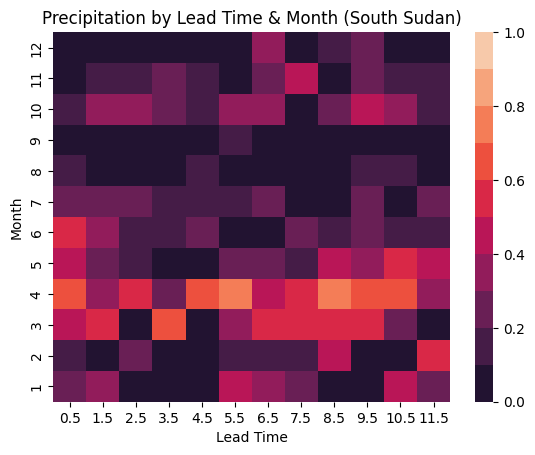

In [91]:
pivot_df = stat_clean.pivot_table(index = 'month', columns = 'lead time', values = 'potential skill')
colormap = sns.color_palette('rocket', 10)
ax = sns.heatmap(pivot_df, vmin=0, vmax=1, cmap = colormap)
ax.invert_yaxis()
plt.title("Precipitation by Lead Time & Month (South Sudan)")
plt.ylabel("Month")
plt.xlabel("Lead Time")
plt.show()